## Домашнее задание

* **Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.**

In [1]:
%matplotlib inline

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import os

warnings.filterwarnings("ignore")

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


## Feature engineering

In [3]:
data_w = data.copy().resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


удалим столбцы hour, day_of_week, dayofyear, dayofmonth, is_prev_holiday, is_next_holiday и year, так как в представлении по неделям эти данные теряют смысл. столбец is_holiday не удаляем, так как он, хоть и относится к конкретному дню, теперь может свидетельствовать о наличии или отсутствии праздников на неделе.

In [4]:
to_drop_list = ['year', 'dayofmonth', 'dayofyear', 'dayofweek', 'hour', 'is_prev_holiday', 'is_next_holiday']
for item in to_drop_list:
    data_w.drop(item, axis=1,inplace=True)
data_w.head()

,PJME_MW,month,quarter,weekofyear,is_holiday
Date,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0.160839
2002-01-13,31487.386905,1.000000,1.0,2.0,0.000000
2002-01-20,31452.880952,1.000000,1.0,3.0,0.000000
2002-01-27,30141.529762,1.000000,1.0,4.0,0.142857
2002-02-03,29196.488095,1.428571,1.0,5.0,0.000000


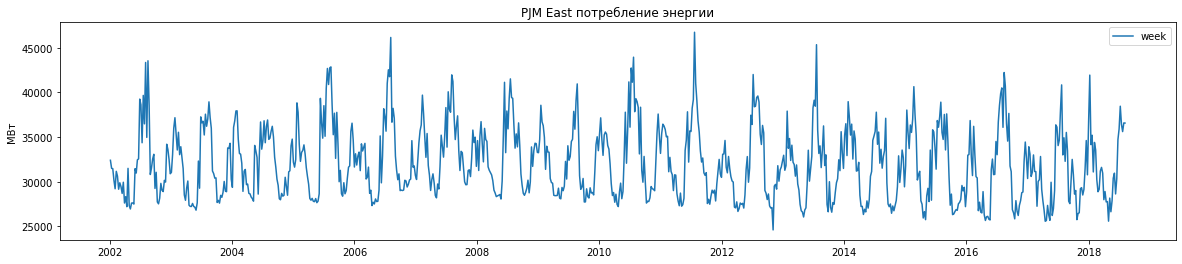

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data_w.index[:], data_w['PJME_MW'].values[:], label='week'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

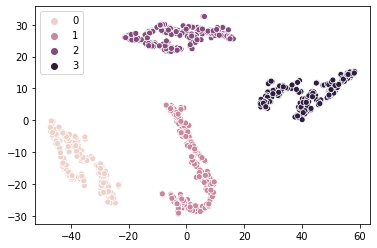

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE 
from sklearn.preprocessing import StandardScaler

scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

clast_0 = DBSCAN(eps=5, leaf_size=15)
X_clast =clast_0.fit_predict(X_t)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

Я проверил, распределение по кластерам не принесло эффекта, так как разделение фактически произошло по кварталам. Добавлять в таблицу этот признак не стал

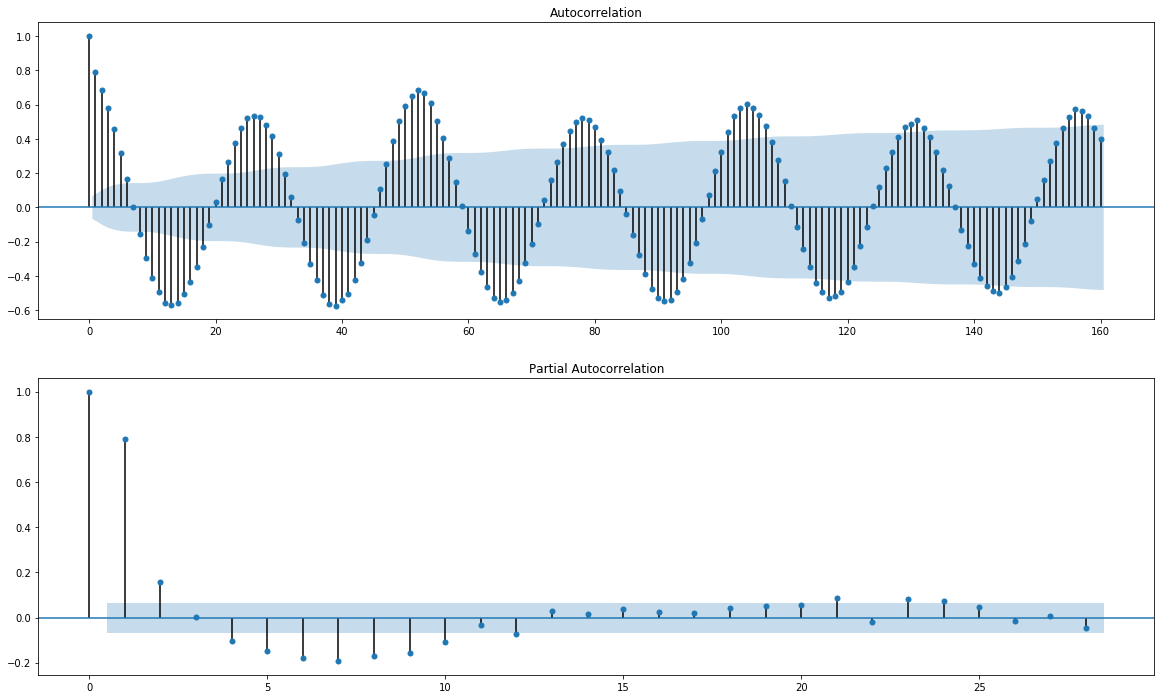

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=160, ax=ax1)
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=28, ax=ax2)
plt.show()

Исходя из автокорреляционного анализа, в качестве исторических данных добавим первые 27 значений (полугодовой цикл). В идеале нужно добавить трехлетний цикл, но при обучений от первых значений придется отказаться из-за отсуствия данных, а позволить выбросить 150 наблюдений из датасета, величиной 866, я думаю, мы не можем, поэтому ограничимся данными за полгода.
Также добавим первые разности на глубину 10

In [8]:
p = 27
for i in range(p):
    data_w['t'+str(i+1)] = 0
    data_w['t'+str(i+1)] = data_w['t'+str(i+1)].astype('float') 
    data_w['t'+str(i+1)].values[i+1:] = data_w['PJME_MW'].values[:-(i+1)]

In [9]:
first_diff = np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

In [10]:
first_diff_w =(first_diff) / data_w.iloc[1:,0].values
data_w['diff1_w'] = 0
data_w['diff1_w'] =  data_w['diff1_w'].astype('float') 
data_w['diff1_w'].values[1:] = np.array(first_diff_w).astype('float32')

In [11]:
first_diff_l = np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

In [12]:
p = 10
for i in range(p):
    data_w['d'+str(p-i)] = 0
    data_w['d'+str(p-i)] = data_w['d'+str(p-i)].astype('float') 
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

Добавим скользящие средние на глубину 4 (месячный цикл)

In [13]:
data_w['w_w4']=data_w['PJME_MW'].rolling(window=4).mean()

In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [15]:
# Экспоненциальное сглаживание
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

## Feature selection

In [16]:
scl_target = StandardScaler() 
p = 27
h = 1
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p, 1))
y = scl_target.fit_transform(target)

y.shape

(838, 1)

In [17]:
scl_x = StandardScaler() 

X_h1 = data_w.iloc[p:-h,:].values
X_h1 = scl_x.fit_transform(X_h1.astype('float64'))
X_h1.shape

(838, 52)

In [18]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

sfk = SelectKBest(f_regression, k=5)
X_new1 = sfk.fit_transform(X_h1, y.ravel())

column_names = data_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 't1', 't2', 'diff1_l', 'w_w4'], dtype='object')

In [19]:
sfp = SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X_h1, y.ravel())
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 't1', 't2', 't12', 'diff1_l', 'w_w4'], dtype='object')

In [20]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X_h1, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X_h1, y.ravel())
X_new3 = sfm.transform(X_h1)

In [21]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков: ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели: ',list_param_m)

Номера признаков k лучших признаков:  [ 0  5  6 34 45]
Номера признаков лучших признаков по процентной форме:  [ 0  5  6 16 34 45]
Номера признаков для выбора по модели:  [ 0 28 34]


In [22]:
list_par_h1=[0, 5, 6, 16, 28, 34, 45]
X_new_h1 = X_h1[:,list_par_h1]
data_w.columns[list_par_h1]

Index(['PJME_MW', 't1', 't2', 't12', 't24', 'diff1_l', 'w_w4'], dtype='object')

**Проделаем то же самое для h=4**

In [24]:
h = 4

target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p, 1))
y_4 = scl_target.fit_transform(target)

X_4 = data_w.iloc[p:-h,:].values
X_4 = scl_x.fit_transform(X_4.astype('float64'))

In [25]:
sfk = SelectKBest(f_regression, k=5)
X_new1 = sfk.fit_transform(X_4, y_4.ravel())

column_names = data_w.columns[sfk.get_support()]
column_names

Index(['t8', 't9', 't10', 't22', 't23'], dtype='object')

In [26]:
sfp = SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X_4, y_4.ravel())
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['t8', 't9', 't10', 't21', 't22', 't23'], dtype='object')

In [27]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X_4, y_4.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X_4, y_4.ravel())
X_new3 = sfm.transform(X_4)

In [28]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков: ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели: ',list_param_m)

Номера признаков k лучших признаков:  [12 13 14 26 27]
Номера признаков лучших признаков по процентной форме:  [12 13 14 25 26 27]
Номера признаков для выбора по модели:  [ 1 12 24 26 27]


In [29]:
list_par_h4=[1, 12, 13, 14, 24, 25, 26, 27]
X_new_h4 = X_4[:,list_par_h4]
data_w.columns[list_par_h4]

Index(['month', 't8', 't9', 't10', 't20', 't21', 't22', 't23'], dtype='object')

Судя по автоматически отобранным признакам, для прямого предсказания на 4 недели вперед не так важно значение потребляемой энергии в сам момент предсказания, а гораздо более важны исторические данные и текущий месяц

## Построение модели

In [30]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

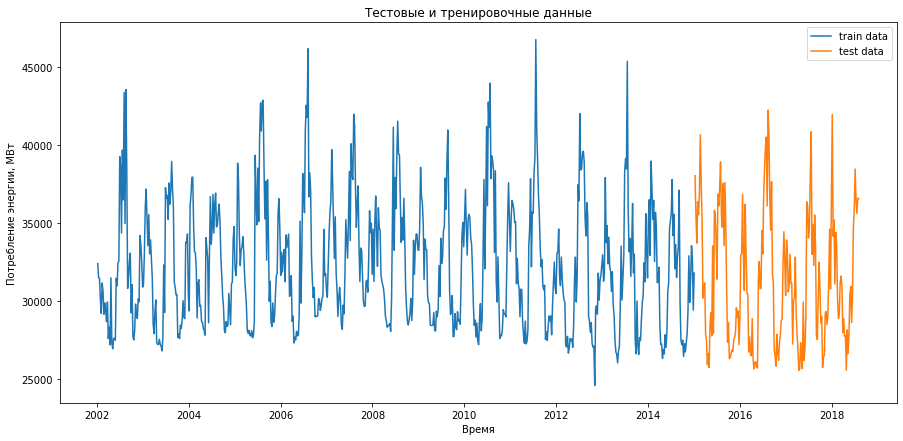

In [31]:
train, test = split_data( data_w, '01-06-2015')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [32]:
X_train_h1 = X_new_h1[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test_h1 = X_new_h1[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

In [33]:
X_train_h4 = X_new_h4[:train.shape[0],:]
y_train_h4 = y_4[:train.shape[0],0]
X_test_h4 = X_new_h4[train.shape[0]:,:]
y_test_h4 = y_4[train.shape[0]:,0]

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

model_h1 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_h4 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_h1.fit(X_train_h1, y_train)
model_h4.fit(X_train_h4, y_train_h4)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [35]:
y_test_pred_h1 = model_h1.predict(X_test_h1)
y_test_pred_h4 = model_h4.predict(X_test_h4)

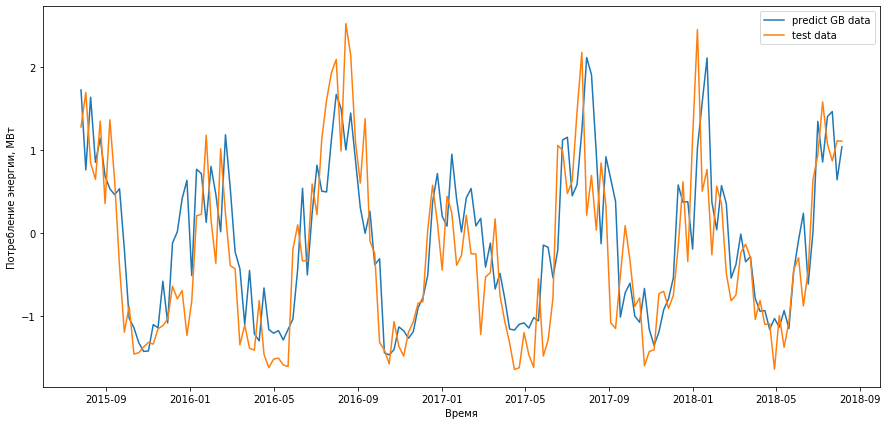

In [36]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1+p:],y_test_pred_h1, label='predict GB data' )
plt.plot(test.index[1+p:],y_test, label='test data')

plt.legend()
plt.show()

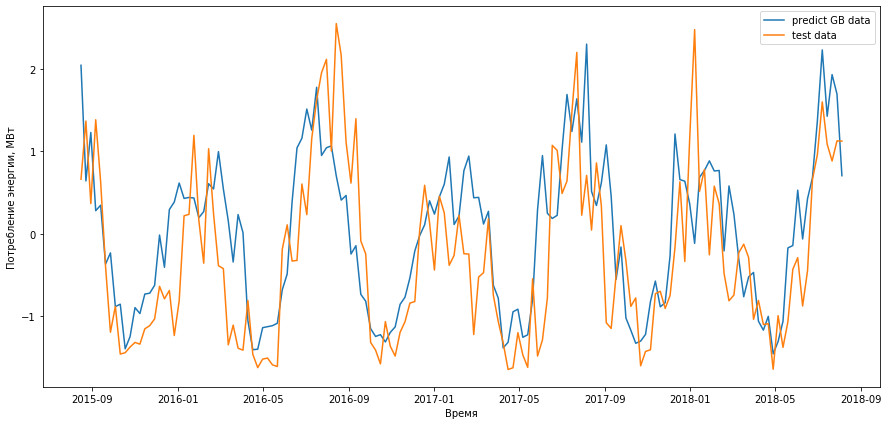

In [37]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_h4, label='predict GB data' )
plt.plot(test.index[h+p:],y_test_h4, label='test data')

plt.legend()
plt.show()

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
er_h1 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),y_pred = scl_target.inverse_transform( y_test_pred_h1))

print('ошибка градиентного бустинга MAPE :  ', er_h1,'%')

ошибка градиентного бустинга MAPE :   6.847446224384809 %


In [40]:
er_h4 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test_h4),y_pred = scl_target.inverse_transform( y_test_pred_h4))

print('ошибка градиентного бустинга MAPE :  ', er_h4,'%')

ошибка градиентного бустинга MAPE :   7.937961567061759 %


Видим, что ошибка не сильно отличается между прямыми предсказаниями на 1 или 4 шага вперед. Попробуем построить рекурсивную модель и сравнить ее с получившейся моделью

##  Рекурсивная модель

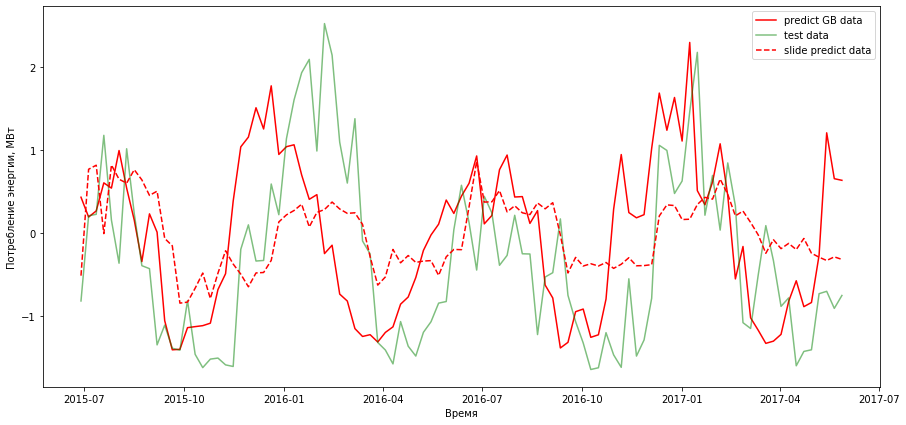

In [43]:
#'PJME_MW', 't1', 't2', 't12', 't24', 'diff1_l', 'w_w4'
p=24
X_test_rec = X_test_h1.copy()
y_test_rec = y_test_pred_h1.copy()
steps = 100
for i in range(steps):
    y_test_rec[p+i] = model_h1.predict(X_test_rec[p+i,:].reshape((1,7)))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_rec[p+i:p+i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_rec[p+i+1, 0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    X_test_rec[p+i+1, 1] = X_test_rec[p+i, 0]
    X_test_rec[p+i+1, 2] = X_test_rec[p+i-1, 0]
    X_test_rec[p+i+1, 3] = X_test_rec[p+i-11, 0]
    X_test_rec[p+i+1, 4] = X_test_rec[p+i-23, 0]
    
    #строим 'd_w7' - признак под номером 3
    X_test_rec[p+i+1, 6] = X_test_rec[p+i-3:p+i+1, 0].mean()
    
    # строим 'diff1_l' - признак под номером 5
    # строим логарифм по значению ряда и скалируем признак по схеме 34-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[34])*scl_x.scale_[34]
    #устанавливаем новое значение для 5
    X_test_rec[p+i+1, 5] = xy_i 
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[p:p+steps+1],y_test_pred_h4[p-1:p+steps], 'r',label='predict GB data' )
plt.plot(test.index[p:p+steps+1],y_test[p-1:p+steps], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p:p+steps+1],y_test_rec[p-1:p+steps], '--r',label='slide predict data')

plt.legend()
plt.show() 

In [51]:
print(f'Настоящее значение ряда при предсказании на 4 точки вперед {y_test[p+3]}')
print(f'Прямое предсказание на 4 точки вперед {y_test_pred_h4[p+3]}')
print(f'Рекурсивная модель {y_test_rec[p+3]}')

Настоящее значение ряда при предсказании на 4 точки вперед 0.1560678561165733
Прямое предсказание на 4 точки вперед 0.5422287703952916
Рекурсивная модель 0.8211047547850246


In [47]:
er_rec = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[p-1:p+steps]),y_pred = scl_target.inverse_transform(y_test_rec[p-1:p+steps]))

print('ошибка рекурсивной модели MAPE :  ', er_rec,'%')

ошибка рекурсивной модели MAPE :   10.275023493104964 %


In [49]:
err = []
for i in range(10):
    err.append(mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[p-1:p+i*10]),
                                              y_pred = scl_target.inverse_transform(y_test_rec[p-1:p+i*10])))
               
print(err)

[4.207257221669095, 10.521087489859275, 12.137349634242083, 11.05633941464518, 10.752870366730088, 10.837313915933212, 10.329659729522758, 10.563689755376371, 10.434567701356045, 10.225239920315309]


Если я все верно сделал, то видим быстрый рост с ошибки с увеличем дальности рекурсивного прогноза, однако после достижения ошибкой значения в 10 процентов, далее происходят только небольшие колебания вокруг этого значения. 

Также видно что пр]мой проноз дает более близкий к правде результат. Думаю, это связано с тем, что мы не накапливаем ошибку в течение предсказаний + предсказываем по другим критериям, которые более эффективны для предсказания именно на эту глубину.